In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 194.7819 - mae: 195.2819
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 191.9080 - mae: 192.4080
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 18.4107 - mae: 18.9047
Epoch 88/100
8/8 [==============================] - 0s 6ms/step - loss: 16.2269 - mae: 16.7217
Epoch 89/100
8/8 [==============================] - 0s 7ms/step - loss: 30.4364 - mae: 30.9343
Epoch 90/100
8/8 [==============================] - 0s 6ms/step - loss: 42.6722 - mae: 43.1706
Epoch 91/100
8/8 [==============================] - 0s 7ms/step - loss: 22.4275 - mae: 22.9242
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 28.3792 - mae: 28.8765
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 32.4697 - mae: 32.9681
Epoch 94/100
8/8 [==============================] - 0s 6ms/step - loss: 29.2470 - mae: 29.7434
Epoch 95/100
8/8 [==============================] - 0s 6ms/step - loss: 51.9364 - mae: 52.4363
Epoch 96/100
8/8 [==============================] - 0s 6ms/step - loss: 62.5566 - mae: 63.0560
Epoch 97/100
8/8 [==============================] - 0s 7ms/step

(1e-08, 0.0001, 0.0, 30.0)

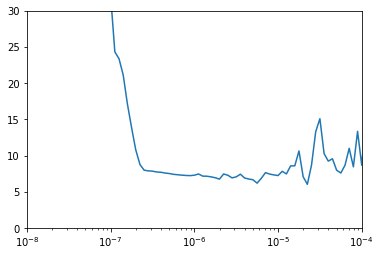

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 8ms/step - loss: 81.7535 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 8ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 7ms/step - loss: 15.9199 - mae: 16.4142
Epoch 4/400
8/8 [==============================] - 0s 7ms/step - loss: 12.2877 - mae: 12.7811
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 10.1468 - mae: 10.6369
Epoch 6/400
8/8 [==============================] - 0s 7ms/step - loss: 16.7255 - mae: 17.2199
Epoch 7/400
8/8 [==============================] - 0s 7ms/step - loss: 13.3785 - mae: 13.8700
Epoch 8/400
8/8 [==============================] - 0s 7ms/step - loss: 10.7132 - mae: 11.2066
Epoch 9/400
8/8 [==============================] - 0s 7ms/step - loss: 10.1092 - mae: 10.5988
Epoch 10/400
8/8 [==============================] - 0s 6ms/step - loss: 8.4907 - mae: 8.9786
Epoch 11/400
8/8 [==============================] - 0s 7ms/st

8/8 [==============================] - 0s 6ms/step - loss: 5.1273 - mae: 5.6056
Epoch 89/400
8/8 [==============================] - 0s 7ms/step - loss: 5.2847 - mae: 5.7671
Epoch 90/400
8/8 [==============================] - 0s 6ms/step - loss: 5.0839 - mae: 5.5640
Epoch 91/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3911 - mae: 4.8665
Epoch 92/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7493 - mae: 5.2270
Epoch 93/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9500 - mae: 5.4288
Epoch 94/400
8/8 [==============================] - 0s 6ms/step - loss: 5.5082 - mae: 5.9896
Epoch 95/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7235 - mae: 5.2021
Epoch 96/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8792 - mae: 5.3592
Epoch 97/400
8/8 [==============================] - 0s 7ms/step - loss: 5.2400 - mae: 5.7212
Epoch 98/400
8/8 [==============================] - 0s 8ms/step - loss: 6.8614 - ma

8/8 [==============================] - 0s 7ms/step - loss: 4.4791 - mae: 4.9550
Epoch 176/400
8/8 [==============================] - 0s 5ms/step - loss: 4.3102 - mae: 4.7847
Epoch 177/400
8/8 [==============================] - 0s 7ms/step - loss: 4.2900 - mae: 4.7643
Epoch 178/400
8/8 [==============================] - 0s 6ms/step - loss: 5.5860 - mae: 6.0633
Epoch 179/400
8/8 [==============================] - 0s 6ms/step - loss: 5.3186 - mae: 5.7989
Epoch 180/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9997 - mae: 5.4788
Epoch 181/400
8/8 [==============================] - 0s 6ms/step - loss: 5.3963 - mae: 5.8761
Epoch 182/400
8/8 [==============================] - 0s 6ms/step - loss: 5.6442 - mae: 6.1276
Epoch 183/400
8/8 [==============================] - 0s 6ms/step - loss: 6.0194 - mae: 6.5008
Epoch 184/400
8/8 [==============================] - 0s 7ms/step - loss: 7.9064 - mae: 8.3957
Epoch 185/400
8/8 [==============================] - 0s 6ms/step - loss: 8

8/8 [==============================] - 0s 14ms/step - loss: 4.3679 - mae: 4.8471
Epoch 263/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6732 - mae: 5.1519
Epoch 264/400
8/8 [==============================] - 0s 12ms/step - loss: 5.1724 - mae: 5.6527
Epoch 265/400
8/8 [==============================] - 0s 11ms/step - loss: 5.3559 - mae: 5.8379
Epoch 266/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6011 - mae: 5.0781
Epoch 267/400
8/8 [==============================] - 0s 10ms/step - loss: 4.0529 - mae: 4.5266
Epoch 268/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6484 - mae: 5.1254
Epoch 269/400
8/8 [==============================] - 0s 12ms/step - loss: 4.2125 - mae: 4.6861
Epoch 270/400
8/8 [==============================] - 0s 10ms/step - loss: 4.1626 - mae: 4.6319
Epoch 271/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3407 - mae: 4.8157
Epoch 272/400
8/8 [==============================] - 0s 10ms/ste

8/8 [==============================] - 0s 13ms/step - loss: 5.3145 - mae: 5.7950
Epoch 349/400
8/8 [==============================] - 0s 14ms/step - loss: 4.9391 - mae: 5.4176
Epoch 350/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4328 - mae: 4.9079
Epoch 351/400
8/8 [==============================] - 0s 13ms/step - loss: 4.5212 - mae: 4.9977
Epoch 352/400
8/8 [==============================] - 0s 13ms/step - loss: 4.2879 - mae: 4.7617
Epoch 353/400
8/8 [==============================] - 0s 12ms/step - loss: 4.1433 - mae: 4.6151
Epoch 354/400
8/8 [==============================] - 0s 13ms/step - loss: 4.4422 - mae: 4.9155
Epoch 355/400
8/8 [==============================] - 0s 14ms/step - loss: 5.9317 - mae: 6.4118
Epoch 356/400
8/8 [==============================] - 0s 14ms/step - loss: 5.5546 - mae: 6.0383
Epoch 357/400
8/8 [==============================] - 0s 12ms/step - loss: 5.2873 - mae: 5.7678
Epoch 358/400
8/8 [==============================] - 0s 13ms/ste

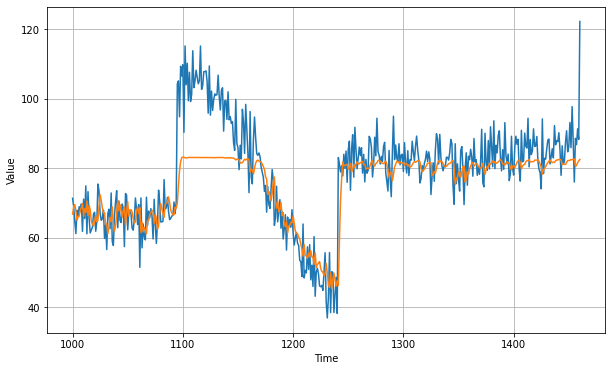

In [8]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.6211767

<Figure size 432x288 with 0 Axes>

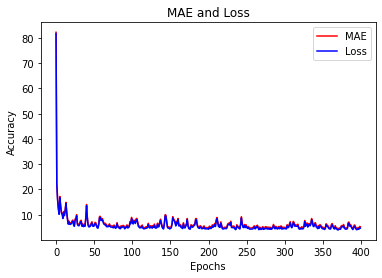

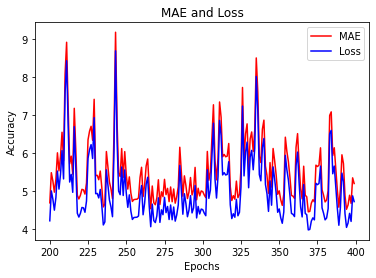

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()